In [1]:
import torch, json
from math import floor
import pandas as pd
import numpy as np

from FileManager.dataManager import dataManager
from AnalyzeTools.prepare import model_eval, pathForSavingModels
from AnalyzeTools.preprocess import preprocessData, removeOutliers, createPeriodData
from AnalyzeTools.superModels import DEEPAR, TFT, RNN

c:\Users\zyf13\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 123


In [2]:
period = 'Day'
predict_type = 'multiple_interval'
test_size = 0.2
max_prediction_length = 15
params_path = './Models'
product_object = json.load(open("./File information.json", "r", encoding='utf8'))

all_experiments= []
for product in product_object.keys():
    for raw_file_name in  product_object[product].keys():
        for product_type in product_object[product][raw_file_name]['product_types']:
            for target in product_object[product][raw_file_name]['targets']:
                all_experiments.append([product, raw_file_name, product_type, target])

In [3]:
n = 0
experiment = all_experiments[n]
product, raw_file_name, product_type, target = experiment
print(f"Product: {product}\nRaw file name: {raw_file_name}\nProduct_type: {product_type}\ntarget: {target}")

Product: pork
Raw file name: (중)경략가격집계 - 소,돼지
Product_type: 돼지 온도체
target: MAX_COST_AMT


In [4]:
df, product_and_product_type, product_attribute = dataManager(raw_file_name, product, product_type, target)

if len(df) == 0:
    raise ValueError("No data!")

df = createPeriodData(df, {'date': 'first', 'others': 'mean'}, period, 'date')

In [5]:
df, input_features = preprocessData(df, 'date', target, period)
# df = removeOutliers(df, test_size, target)

train_x_axis = df['date'][:-1*floor(len(df) * test_size)].values if type(test_size) == float else df['date'][:-1*test_size]
predictions_x_axis = df['date'][-1*floor(len(df) * test_size):].values if type(test_size) == float else df['date'][-1*test_size:]


-->Feature scores:
                 Features        Scores
6  DEFECT_MAX_COST_AMT  6.811574e+10
1         MIN_COST_AMT  1.222592e+04
5  DEFECT_MIN_COST_AMT  1.222443e+04
2         SUM_COST_AMT  4.538033e+02
7  DEFECT_SUM_COST_AMT  4.537454e+02
8    DEFECT_SUM_WEIGHT  2.279391e+01
3           SUM_WEIGHT  2.277102e+01
4           DEFECT_CNT  1.084715e+01
0                  CNT  1.083094e+01

-->TOP K features:
   ['MIN_COST_AMT', 'SUM_COST_AMT', 'DEFECT_MIN_COST_AMT', 'DEFECT_MAX_COST_AMT']

-->Final features:
  ['MIN_COST_AMT', 'SUM_COST_AMT']


In [6]:
data = df.copy()

data['time_idx'] = range(len(data))
data['group'] = product

training_cutoff = floor(len(data) * (1 - test_size))

if period == 'Day':
    max_encoder_length = 30 # 30
    batch_size = 32 # 32
elif period == 'Week':
    max_encoder_length = 14
    batch_size = 16
elif period == 'Month':
    max_encoder_length = 3
    batch_size = 4

group = ['group']
# time_varying_known_categoricals = ['month', 'week']
time_varying_known_categoricals = []
time_varying_unknown_categoricals = []
time_varying_known_reals = ['time_idx']
time_varying_unknown_reals = input_features + [target]

In [7]:
dl_searchCV_params = {
    'base_dir': params_path,
    'product_and_product_type': product_and_product_type,
    'attribute': product_attribute,
    'raw': raw_file_name,
    'predict_type': predict_type,
    'period': period,
    'step': max_prediction_length,
    'save': True
}

In [21]:
print("\nTFT")
training_params = {
    'max_epochs': 20, 
    'n_trials': 5, 
    'output_size': 7, 
    'hidden_size_range': (8, 128), 
    'hidden_continuous_size_range': (8, 16),
    'attention_head_size_range': (1, 2) 
}
saving_dir = pathForSavingModels('TFT', **dl_searchCV_params)
model, val_dataloader = TFT(
    data,
    training_cutoff,
    target,
    group,
    max_encoder_length,
    max_prediction_length,
    time_varying_unknown_categoricals,
    time_varying_known_categoricals,
    time_varying_known_reals,
    time_varying_unknown_reals,
    batch_size,
    saving_dir,
    predict_type,
    **training_params,
)





TFT


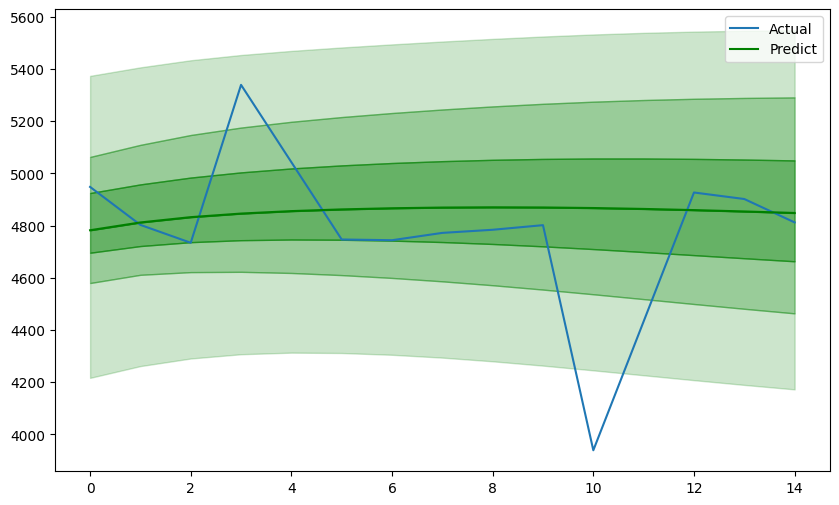

In [22]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
raw_predictions, x = model.predict(val_dataloader, mode='quantiles', return_x=True)
model_eval(actuals.numpy()[15*0], raw_predictions.numpy()[15*0], stdout=False, vis=True, beautiful=False, interval=True)

In [15]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(564.0460)

In [16]:
from pytorch_forecasting.metrics import MAPE, NormalDistributionLoss, QuantileLoss, SMAPE

In [17]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
raw_predictions, x = model.predict(val_dataloader, mode='raw', return_x=True)

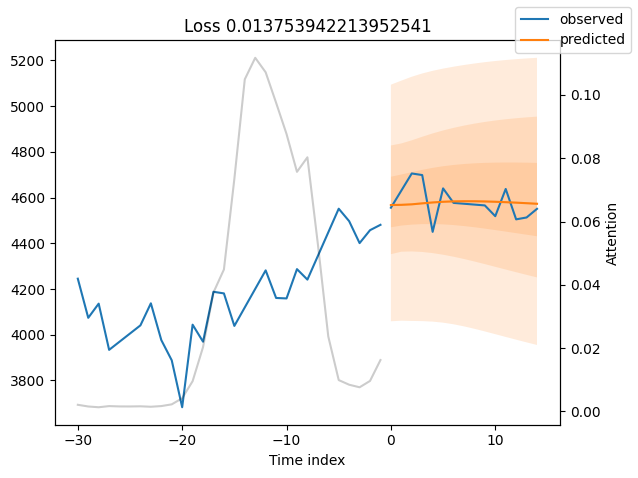

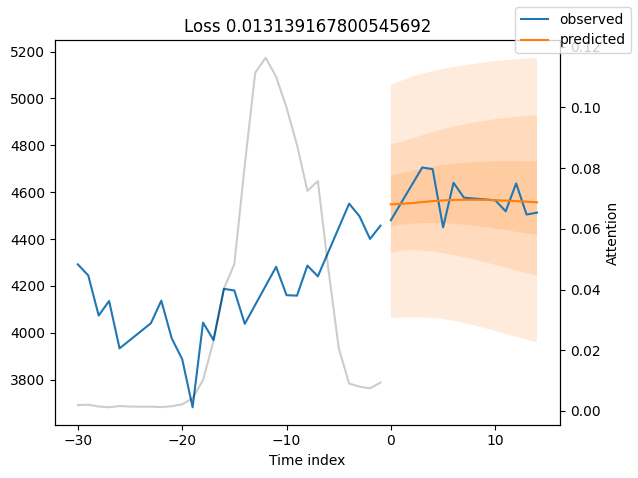

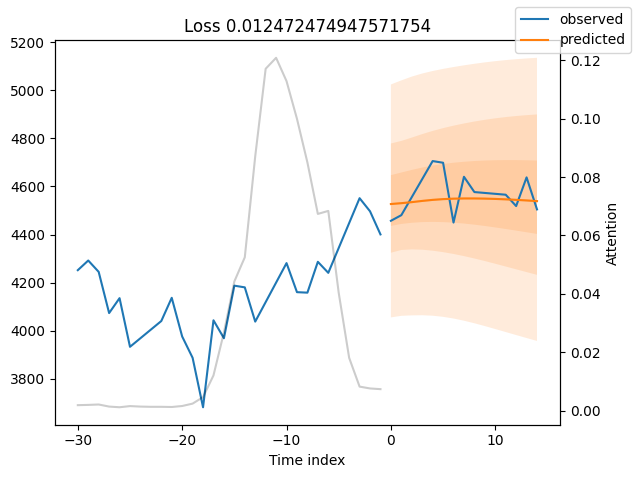

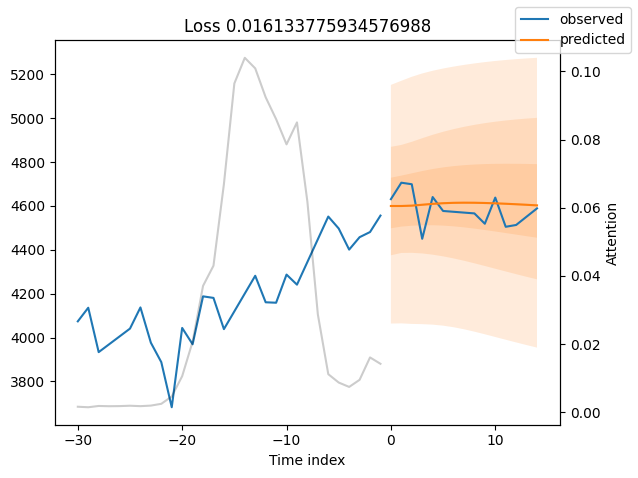

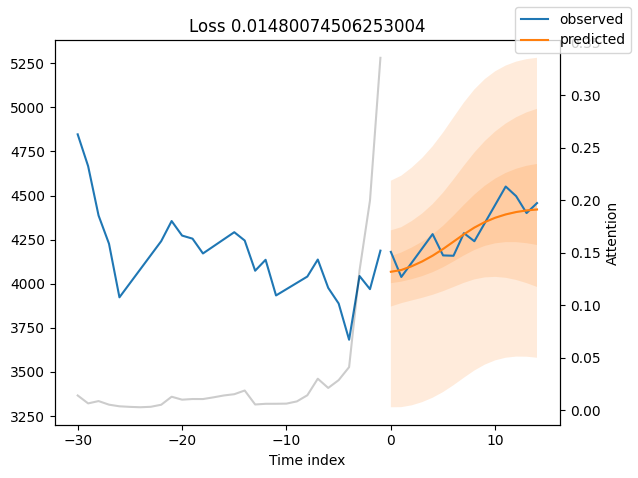

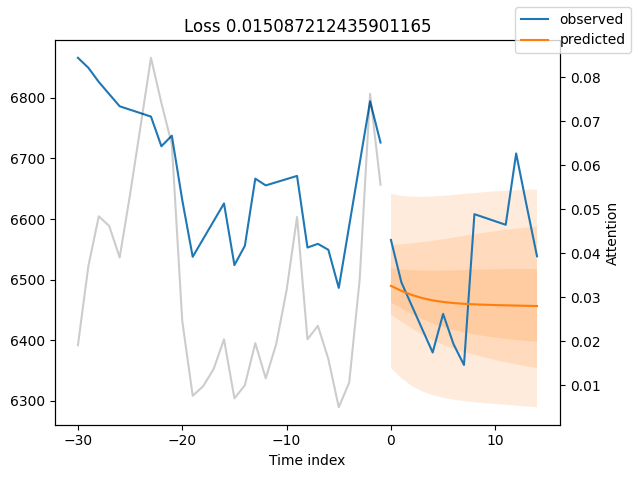

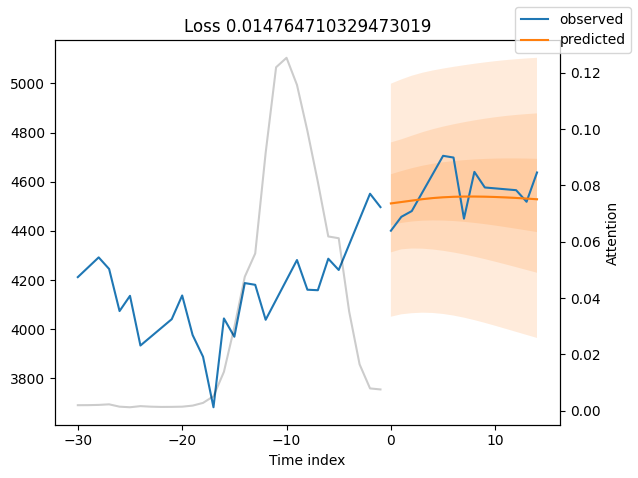

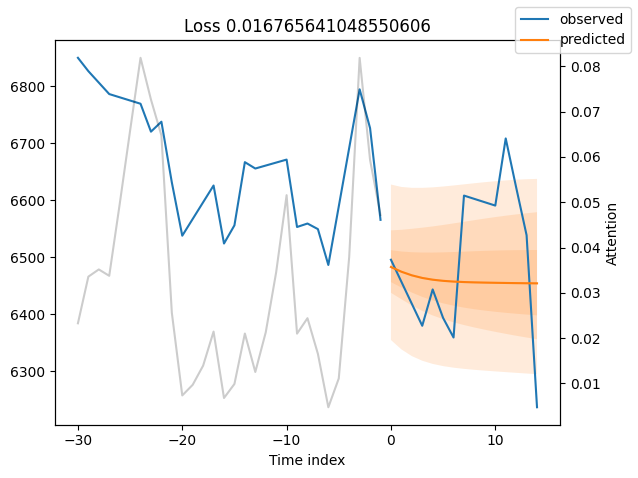

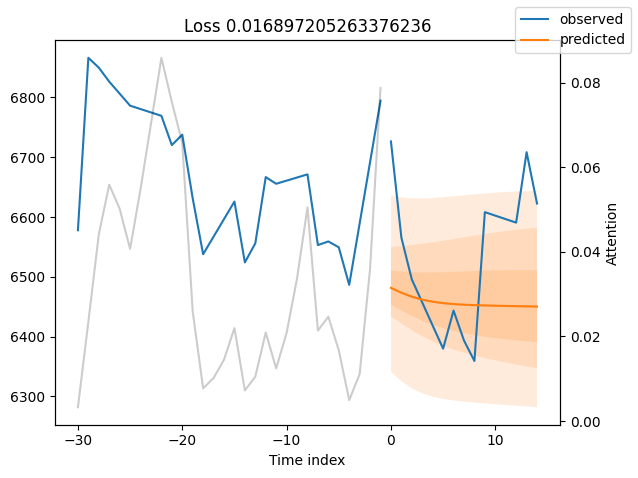

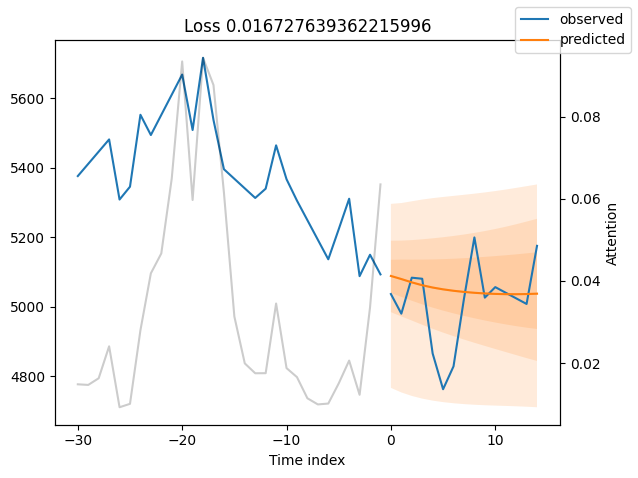

In [18]:
# calcualte metric by which to display
predictions = model.predict(val_dataloader)
mean_losses = MAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=False)  # sort losses
for idx in range(10):  # plot 10 examples
    model.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=model.loss.quantiles)
    )

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x200 with 1 Axes>,
 'encoder_variables': <Figure size 700x300 with 1 Axes>,
 'decoder_variables': <Figure size 700x225 with 1 Axes>}

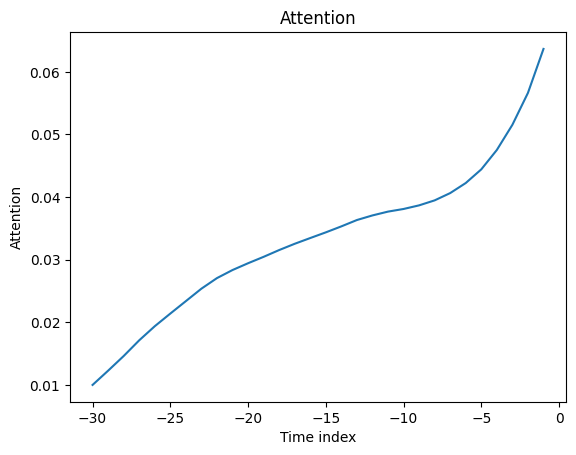

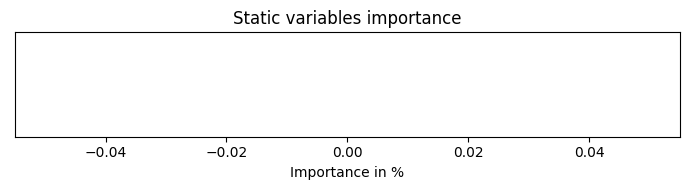

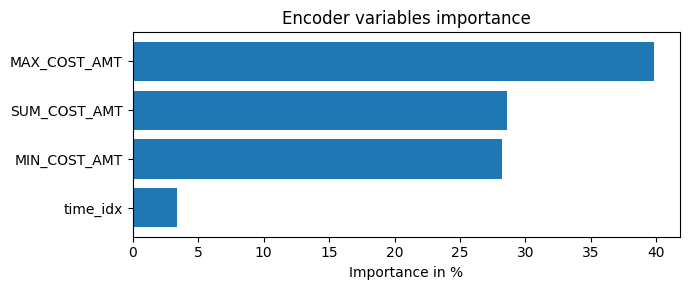

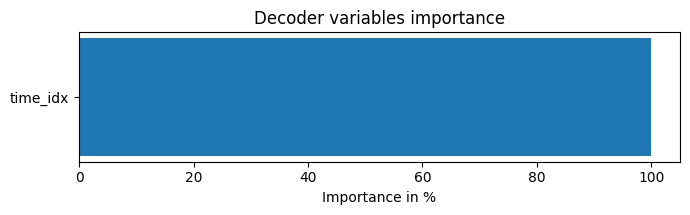

In [19]:
interpretation = model.interpret_output(raw_predictions, reduction="sum")
model.plot_interpretation(interpretation)